In [1]:
# default_exp gan.model

# gan.model

> API details.

In [2]:
# hide
# export

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.nn import BCELoss, CrossEntropyLoss

from fastrenewables.synthetic_data import DummyDataset
from fastrenewables.timeseries.model import TemporalCNN

In [3]:
# export

def flatten_ts(x):
    """assumes matrix of shape (n_samples, n_features, ts_length)"""
    if len(x.shape) in [1,2]:
        return x

    n_samples, n_features, ts_length = x.shape

    if isinstance(x, np.ndarray):
        x = x.swapaxes(1,2)
    else:
        x = x.permute(0,2,1)
    x = x.reshape(n_samples*ts_length, n_features)
    return x

In [4]:
# export

def LinBnAct(si, so, use_bn, act_cls):
    layers = [nn.Linear(si, so)]
    if use_bn:
        layers += [nn.BatchNorm1d(so)]
    if act_cls is not None:
        layers += [act_cls]
    
    return nn.Sequential(*layers)

In [5]:
# export

class GANMLP(torch.nn.Module):
    def __init__(self, ann_structure, bn_cont=False, act_fct=torch.nn.ReLU, final_act_fct=nn.Sigmoid, embedding_module=None, transpose=False):
        # transpose doesn't change anything here but is needed for consistency
        super(GANMLP, self).__init__()
        
        n_cont = ann_structure[0]
        if embedding_module is not None:
            emb_sz = []
            ann_structure[0] = ann_structure[0] + embedding_module.no_of_embeddings

        self.embedding_module = embedding_module
        
        layers = []
        for idx in range(1, len(ann_structure)):
            cur_use_bn = bn_cont
            cur_act_fct = act_fct()
            if idx == 1 and not bn_cont:
                cur_use_bn = False
            if idx == len(ann_structure)-1:
                cur_act_fct = None
                cur_use_bn = False
                
            layer = LinBnAct(ann_structure[idx-1], ann_structure[idx], cur_use_bn , cur_act_fct)
            layers.append(layer)
        if final_act_fct is not None:
            layers.append(final_act_fct())
        
        self.model = nn.Sequential(*layers)

    def forward(self, x_cat, x_cont):
        if self.embedding_module is not None:
            cat = self.embedding_module(x_cat)
            x_cont = torch.cat([x_cat, x_cont], 1)
        
        return self.model(x_cont)

GANMLP(
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=8, out_features=1, bias=True)
    )
    (2): Sigmoid()
  )
)


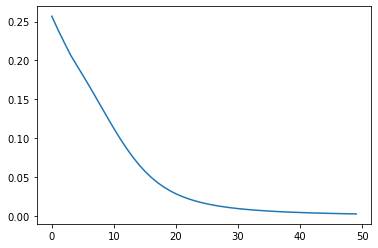

In [6]:
# hide

model = GANMLP(ann_structure=[4, 8, 1])
print(model)
opt = torch.optim.Adam(params=model.parameters())
loss = torch.nn.MSELoss()
data = DummyDataset(n_samples=100, n_cat_feats=0, n_cont_feats=4, n_targets=1, n_dim=2)
dl = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, drop_last=True)

errors = []

for epoch in range(50):
    for x_cat, x_cont, y in dl:
        opt.zero_grad()
        pred = model(x_cat, x_cont)
        error = loss(pred, y)
        error.backward()
        opt.step()
    errors.append(error.item())
    
assert(errors[0] > errors[-1]) 

plt.figure()
plt.plot(errors)
plt.show()

In [7]:
# export

class GANCNN(torch.nn.Module):
    def __init__(self, ann_structure, bn_cont=False, act_fct=nn.ReLU, final_act_fct=nn.Sigmoid, embedding_module=None, transpose=False):
        super(GANCNN, self).__init__()
        
        self.model = TemporalCNN(cnn_structure=ann_structure, batch_norm_cont=bn_cont, cnn_type='cnn', act_func=act_fct, final_activation=final_act_fct, transpose=transpose)
        
    def forward(self, x_cat, x_cont):
        return self.model(x_cat, x_cont)

GANCNN(
  (model): TemporalCNN(
    (layers): TemporalConvNet(
      (temporal_blocks): Sequential(
        (0): BasicTemporalBlock(
          (conv): ConvLayer(
            (0): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (1): ReLU()
          )
        )
        (1): BasicTemporalBlock(
          (conv): ConvLayer(
            (0): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (1): Sigmoid()
          )
        )
      )
    )
  )
)


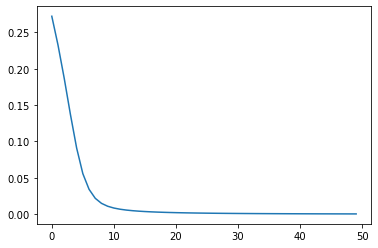

In [8]:
# hide

model = GANCNN(ann_structure=[4, 8, 1])
print(model)
opt = torch.optim.Adam(params=model.parameters())
loss = torch.nn.MSELoss()
data = DummyDataset(n_samples=100, n_cat_feats=0, n_cont_feats=4, n_targets=1, n_dim=3)
dl = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, drop_last=True)

errors = []

for epoch in range(50):
    for x_cat, x_cont, y in dl:
        opt.zero_grad()
        pred = model(x_cat, x_cont)
        error = loss(pred, y)
        error.backward()
        opt.step()
    errors.append(error.item())
    
assert(errors[0] > errors[-1]) 

plt.figure()
plt.plot(errors)
plt.show()

In [9]:
# export
    
class GAN(nn.Module):
    
    def __init__(self, generator, discriminator, gen_optim, dis_optim, n_z=100, auxiliary=False, auxiliary_weighting_factor=1):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optim = gen_optim
        self.dis_optim = dis_optim
        self.n_z = n_z
        self.real_loss = []
        self.fake_loss = []
        self.auxiliary = auxiliary
        self.bce_loss = BCELoss()
        self.auxiliary_loss_function = CrossEntropyLoss()
        self.auxiliary_weighting_factor=auxiliary_weighting_factor
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.to_device(self.device)
        
    def noise(self, x):
        if x.dim() == 2:
            z = torch.randn(x.shape[0], self.n_z).to(self.device)
        elif x.dim() == 3:
            z = torch.randn(x.shape[0], self.n_z, x.shape[2]).to(self.device)
        return z
    
    def to_device(self, device):
        self.device = device
        self.generator = self.generator.to(device)
        self.discriminator = self.discriminator.to(device)
        self.bce_loss = self.bce_loss.to(device)
        self.auxiliary_loss_function = self.auxiliary_loss_function.to(device)
        
    def _split_pred(self, y):
        if self.auxiliary:
            y, class_probs = y
        else:
            y, class_probs = y, None
        return y, class_probs
    
    def auxiliary_loss(self, class_probs, y):
        return self.auxiliary_loss_function(class_probs, y.ravel().to(torch.int64))*self.auxiliary_weighting_factor
    
    def train_generator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.generator.zero_grad()
        x_cont_fake = self.generator(x_cat, z)
        y_fake = self.discriminator(None, x_cont_fake)  
        y_fake, class_probs = self._split_pred(y_fake)
        loss = self.bce_loss(y_fake, torch.ones_like(y_fake))
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            loss = (loss + aux_loss)/2
        loss.backward()
        self.gen_optim.step()
        return
    
    def train_discriminator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        y_real = self.discriminator(None, x_cont)
        y_real, class_probs = self._split_pred(y_real)
        real_loss = self.bce_loss(y_real, torch.ones_like(y_real))
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            real_loss = (real_loss + aux_loss)/2
        
        real_loss.backward()
        self.dis_optim.step()
        self.real_loss.append(real_loss.item())
        
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        x_cont_fake = self.generator(x_cat, z).detach()
        y_fake = self.discriminator(None, x_cont_fake)
        y_fake, class_probs = self._split_pred(y_fake)
        
        fake_loss =  self.bce_loss(y_fake, torch.zeros_like(y_fake))
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            fake_loss = (fake_loss + aux_loss)/2
            
        fake_loss.backward()
        self.dis_optim.step()
        self.fake_loss.append(fake_loss.item())
        return
    
    def forward(self, x_cat, x_cont):
        z = self.noise(x_cont)
        x_gen = self.generator(x_cat, z)
        assert(x_gen.shape == x_cont.shape)
        self.discriminator(None, x_gen)
        return

In [10]:
generator = GANMLP([100, 50, 4])
discriminator = GANMLP([4, 50, 1])
gen_optim = torch.optim.Adam(generator.parameters())
dis_optim = torch.optim.Adam(discriminator.parameters())
model = GAN(generator, discriminator, gen_optim, dis_optim)
print(model)

data = DummyDataset(n_samples=100, n_cat_feats=0, n_cont_feats=4, n_targets=1, n_dim=2)
dl = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, drop_last=True)
    
for x_cat, x_cont, y in dl:
    model(x_cat, x_cont)

GAN(
  (generator): GANMLP(
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=50, out_features=4, bias=True)
      )
      (2): Sigmoid()
    )
  )
  (discriminator): GANMLP(
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=4, out_features=50, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=50, out_features=1, bias=True)
      )
      (2): Sigmoid()
    )
  )
  (bce_loss): BCELoss()
  (auxiliary_loss_function): CrossEntropyLoss()
)


In [11]:
# export

class WGAN(GAN):
    def __init__(self, generator, discriminator, gen_optim, dis_optim, n_z=100, clip=0.001, auxiliary=False):
        super(WGAN, self).__init__(generator, discriminator, gen_optim, dis_optim, n_z, clip, auxiliary)
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optim = gen_optim
        self.dis_optim = dis_optim
        self.n_z = n_z
        self.clip = clip
        self.auxiliary = auxiliary
        self.real_loss = []
        self.fake_loss = []
        
    def train_generator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.generator.zero_grad()
        x_cont_fake = self.generator(x_cat, z)
        y_fake = self.discriminator(None, x_cont_fake)
        loss = - y_fake.mean()
        loss.backward()
        self.gen_optim.step()
        return
    
    def train_discriminator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        y_real = self.discriminator(None, x_cont)
        real_loss = - y_real.mean()
        real_loss.backward()
        self.dis_optim.step()
        self.real_loss.append(real_loss.item())
        
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        x_cont_fake = self.generator(x_cat, z).detach()
        y_fake = self.discriminator(None, x_cont_fake)
        fake_loss = y_fake.mean()
        fake_loss.backward()
        self.dis_optim.step()
        self.fake_loss.append(fake_loss.item())
        
        for p in self.discriminator.parameters():
            p = torch.clamp(p, -self.clip, self.clip)
        return

In [12]:
generator = GANMLP([100, 50, 4])
discriminator = GANMLP([4, 50, 1], final_act_fct=None)
gen_optim = torch.optim.Adam(generator.parameters())
dis_optim = torch.optim.Adam(discriminator.parameters())
model = WGAN(generator, discriminator, gen_optim, dis_optim)
print(model)

data = DummyDataset(n_samples=100, n_cat_feats=0, n_cont_feats=4, n_targets=1, n_dim=2)
dl = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, drop_last=True)
    
for x_cat, x_cont, y in dl:
    model(x_cat, x_cont)

WGAN(
  (generator): GANMLP(
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=50, out_features=4, bias=True)
      )
      (2): Sigmoid()
    )
  )
  (discriminator): GANMLP(
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=4, out_features=50, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=50, out_features=1, bias=True)
      )
    )
  )
  (bce_loss): BCELoss()
  (auxiliary_loss_function): CrossEntropyLoss()
)


In [13]:
#export    

class AuxiliaryDiscriminator(torch.nn.Module):
    def __init__(self, basic_discriminator, n_classes, final_input_size, len_ts=1, model_type='mlp'):
        super(AuxiliaryDiscriminator, self).__init__()
        self.basic_discriminator = basic_discriminator
        self.n_classes = n_classes
        self.final_input_size = final_input_size
        self.len_ts = len_ts
        self.model_type = model_type
        
        if self.model_type == 'mlp':
            self.adv_layer = nn.Sequential(nn.Linear(self.final_input_size, 1), nn.Sigmoid())
            self.aux_layer = nn.Sequential(nn.Linear(self.final_input_size, self.n_classes), nn.Softmax(dim=1))
        elif self.model_type == 'cnn':
            self.adv_layer = nn.Sequential(nn.Flatten(1), nn.Linear(self.final_input_size*self.len_ts, 1), nn.Sigmoid())
            self.aux_layer = nn.Sequential(nn.Flatten(1), nn.Linear(self.final_input_size*self.len_ts, self.n_classes), nn.Softmax(dim=1))
        
    def forward(self, cats, conts):
        out = self.basic_discriminator(cats, conts)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return (validity, label)

In [14]:
generator = GANMLP([100, 50, 4])
discriminator = GANMLP([4, 50], final_act_fct=None)
discriminator = AuxiliaryDiscriminator(basic_discriminator=discriminator, n_classes=4, final_input_size=50, len_ts=1, model_type='mlp')
gen_optim = torch.optim.Adam(generator.parameters())
dis_optim = torch.optim.Adam(discriminator.parameters())
model = WGAN(generator, discriminator, gen_optim, dis_optim)
print(model)

data = DummyDataset(n_samples=100, n_cat_feats=0, n_cont_feats=4, n_targets=1, n_dim=2)
dl = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, drop_last=True)
    
for x_cat, x_cont, y in dl:
    model(x_cat, x_cont)

WGAN(
  (generator): GANMLP(
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=50, out_features=4, bias=True)
      )
      (2): Sigmoid()
    )
  )
  (discriminator): AuxiliaryDiscriminator(
    (basic_discriminator): GANMLP(
      (model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=4, out_features=50, bias=True)
        )
      )
    )
    (adv_layer): Sequential(
      (0): Linear(in_features=50, out_features=1, bias=True)
      (1): Sigmoid()
    )
    (aux_layer): Sequential(
      (0): Linear(in_features=50, out_features=4, bias=True)
      (1): Softmax(dim=1)
    )
  )
  (bce_loss): BCELoss()
  (auxiliary_loss_function): CrossEntropyLoss()
)


In [15]:
# export

def get_gan_model(gan_type, model_type, structure, len_ts=1, n_classes=1):
    gen_structure = structure.copy()
    structure.reverse()
    dis_structure = structure
    dis_structure[-1] = 1
    n_z = gen_structure[0]
    
    if model_type == 'mlp':
        model_fct = GANMLP
    elif model_type == 'cnn':
        model_fct = GANCNN
    
    if gan_type == 'bce' or gan_type == 'aux':
        final_act_dis = nn.Sigmoid
        opt_fct = torch.optim.Adam
        gan_class = GAN
    elif gan_type == 'wgan':
        final_act_dis = None
        opt_fct = torch.optim.RMSprop
        gan_class = WGAN
       
    generator = model_fct(ann_structure=gen_structure, act_fct=nn.ReLU, final_act_fct=nn.Sigmoid, transpose=True)
    if gan_type == 'aux':
        auxiliary = True
        dis_structure = dis_structure[:-1]
        final_input_size = dis_structure[-1]
        discriminator = model_fct(ann_structure=dis_structure, act_fct=nn.LeakyReLU, final_act_fct=final_act_dis)
        discriminator = AuxiliaryDiscriminator(basic_discriminator=discriminator, n_classes=n_classes, final_input_size=final_input_size, len_ts=len_ts, model_type=model_type)  
    else:
        auxiliary = False
        discriminator = model_fct(ann_structure=dis_structure, act_fct=nn.LeakyReLU, final_act_fct=final_act_dis)
        
    gen_opt = opt_fct(params=generator.parameters())
    dis_opt = opt_fct(params=discriminator.parameters())
    model = gan_class(generator=generator, discriminator=discriminator, gen_optim=gen_opt, dis_optim=dis_opt, n_z=n_z, auxiliary=auxiliary)

    return model